## Basics

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    #key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.k_entry,p.k_f,p.prod_alpha,p.dt)
    key = (p.num_z,p.num_v,p.z_corr,p.prod_var_z,p.num_q,p.q_0,p.prod_q,p.s_job,p.alpha,p.kappa,p.dt,p.u_bf_m,p.min_wage)
    # Check if the key exists in the saved results
    if key in all_results:
        print(key)
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None
new_baseline = {
   'q_0': 0.56602, 'prod_q':	0.50425,'u_bf_m':	2.34264/4,'s_job':	0.779616,'alpha':	0.79,'z_corr':	0.946006,'prod_var_z':	0.646317
}
another_baseline = { 
'q_0':     0.7094052599792449,
'prod_q':    0.48553336143372877,
'u_bf_m':    0.5884034329521419,
's_job':    0.35319166225985643,
'alpha':    0.15424752943946796,
'z_corr':    0.8809848371620363,
'prod_var_z':    0.6063338243114458
}
from primitives import Parameters
p = Parameters(overwrite=new_baseline)
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats
plts=Plots(p)

In [3]:
from CRS_HMQ_full import MultiworkerContract
mwc_J=MultiworkerContract(p)
model=mwc_J.J_sep(update_eq=1,s=0,print_choice=True)

In [ ]:
# Load the temp objects

#with open("results_GE.pkl", "rb") as file:
#    all_results = pickle.load(file)
#results_GE = get_results_for_p(p,all_results)


with open("model_GE.pkl", "rb") as file:
    all_results = pickle.load(file)
model = get_results_for_p(p,all_results)
if model is None:
    from CRS_HMQ_full import MultiworkerContract
    mwc_J=MultiworkerContract(p)
    model=mwc_J.J_sep(update_eq=1,s=0)

In [ ]:
def cf_model_to_life(p,first_best, update_prod=False, pr_cache=False):
    """
    We simulate the response of several variables to a shock to z and x.
    We fixed the cross-section distribution of (X,Z) and set rho to rho_start
    We apply a permanent shock to either X or Z, and fix the employment relationship, as well as (X,Z)
    We then simulate forward the Rho, and the wage, and report several different variable of interest.
    """
    import pandas as pd
    from scipy.ndimage import map_coordinates

    class RegularGridInterpolator:
        def __init__(self, points, values, method='linear'):
            self.limits = np.array([[min(x), max(x)] for x in points])
            self.values = np.asarray(values, dtype=float)
            self.order = {'linear': 1, 'cubic': 3, 'quintic': 5}[method]

        def __call__(self, xi):
            """
            `xi` here is an array-like (an array or a list) of points.

            Each "point" is an ndim-dimensional array_like, representing
            the coordinates of a point in ndim-dimensional space.
            """
            # transpose the xi array into the ``map_coordinates`` convention
            # which takes coordinates of a point along columns of a 2D array.
            xi = np.asarray(xi).T

            # convert from data coordinates to pixel coordinates
            ns = self.values.shape
            coords = [(n-1)*(val - lo) / (hi - lo)
                  for val, n, (lo, hi) in zip(xi, ns, self.limits)]

            # interpolate
            return map_coordinates(self.values, coords,
                               order=self.order,
                               cval=np.nan,mode='nearest')  # fill_value    
    
    nt = 20*4
    # we load the model
    with open("model_GE.pkl", "rb") as file:
        all_results = pickle.load(file)
    model = get_results_for_p(p,all_results)
    if model is None:
        from CRS_HMQ_full import MultiworkerContract
        mwc_J=MultiworkerContract(p)
        model=mwc_J.J_sep(update_eq=1,s=0)
    #model = wd.FullModel.load("res_main_model.pkl")


    # we simulate from the model to get a cross-section
    from simulate import Simulator
    sim = Simulator(model, p)
    sdata = sim.simulate().get_sdata()
    print("Solved and simulated")
    # we construct the different starting values
    tm = sdata['t'].max()
    d0 = sdata.query('e==1 & t==@tm')[['q','z','h','r']]
    z_grid = np.linspace(0,p.num_z-1,p.num_z)
    # we start at target rho
    #rho_target_interpolator = RegularGridInterpolator((z_grid, model.Q_grid), model.target_rho) 
    #points = np.column_stack((d0['z'],d0['q']))
    #Or, without the double interpolation...
    R0 = np.zeros_like(d0['z'])
    for iz in range(p.num_z):
        Ixz = np.where(d0['z']==iz)
        R0[Ixz] = np.interp(d0.query('z==@iz')['q'],model.Q_grid,model.target_rho[iz,:])
    print("target_rho range",R0.min(),R0.max())
    #np.interp(d0['q'],model.Q_grid,model.target_rho[d0['z'],:])#[ (d0['z'],d0['q']) ]
    #R0 = rho_target_interpolator (points)
    # starting with Z shocks
    def get_z_pos(pr):
        Z1_pos = np.minimum(sdata['z'].max(), d0['z'] + 1)
        Z1_pos = np.where(np.random.uniform(size=len(Z1_pos)) > pr, Z1_pos, d0['z']  )
        return(Z1_pos)

    def get_z_neg(pr):
        Z1_neg = np.maximum(0, d0['z'] - 1)
        Z1_neg = np.where(np.random.uniform(size=len(Z1_neg)) > pr, Z1_neg, d0['z']  )
        return(Z1_neg)

    # simulate a control group
    var_name = {'q':r'proportion of high quality matches $q$', 
                'w':r'log earnings $\log w$', 
                'W1':'worker promised value $v$', 
                'lceq':'worker cons. eq.', 
                'Pi':r'firm present value $J(y,v,q)$', 
                'y':r'log match productivity shock', 
                'pr_j2j':'J2J probability', 
                'pr_e2u':'E2U probability',
                'target_wage':r'log of target wage $\log w^*(y,q)$',
                'vs':'worker search decision $v_1$'}
    var_list = { k:'mean' for k in var_name.keys()  }

    def sim_agg(dd):
        # compute consumption equivalent for W1
        dd['lceq'] = model.pref.log_consumption_eq(dd['W1'])
        dd['lpeq'] = model.pref.log_profit_eq(dd['W1'])
        return(dd.groupby('t').agg(var_list))

    sdata0 = sim_agg(sim.simulate_force_ee(d0['q'],d0['z'],d0['h'],R0, nt,  update_z=False, pb=True))
    print("Control group simulated")
    # we run for a grid of probabilities
    if pr_cache:
        with open("res_cf_pr_fb{}.json".format(first_best)) as f:
            all = json.load(f)
    else:
        all = []
        vec = np.linspace(0,1,10)
        for i in range(len(vec)):
            res = {}
            res['pr'] = vec[i]
            pr = vec[i]
            res['z_pos'] = sim.simulate_force_ee(
                    d0['q'], get_z_pos(pr), d0['h'],R0, nt, 
                     update_z=False, pb=True)['y'].mean() 
            res['z_neg'] = sim.simulate_force_ee(
                    d0['q'], get_z_neg(pr), d0['h'],R0, nt, 
                     update_z=False, pb=True)['y'].mean() 
            all.append(res)

        # save to file!
        # with open("res_cf_pr_fb{}.json".format(first_best), 'w') as fp:
        #     json.dump(all, fp)
    
    df = pd.DataFrame(all)

    df = df.sort_values(['z_pos'])
    pr_z_pos = np.interp( sdata0['y'].mean() + 0.1, df['z_pos'] , df['pr'] )
    df = df.sort_values(['z_neg'])
    pr_z_neg = np.interp( sdata0['y'].mean() - 0.1, df['z_neg'] , df['pr'] )
    

 
    sdata0 = sim_agg(sim.simulate_force_ee(d0['q'],d0['z'],d0['h'],R0, nt, update_z=update_prod, pb=True))
    print("Ran for a grid of probabilities?")
    # finaly we simulate at the probabilities that we have chosen.
    sdata_z_pos = sim_agg(sim.simulate_force_ee(
        d0['q'],get_z_pos(pr_z_pos),d0['h'],R0, nt, 
        update_z=update_prod,pb=True))

    sdata_z_neg = sim_agg(sim.simulate_force_ee(
        d0['q'],get_z_neg(pr_z_neg),d0['h'],R0, nt, 
        update_z=update_prod,pb=True))

    # preparing the lead and lag plots
    pp0 = lambda v : np.concatenate([ np.zeros(5), v ])
    ppt = lambda v : np.concatenate([ [-4,-3,-2,-1,0], v ])
    
    to_plot = {'w','pr_j2j','pr_e2u','vs','q','Pi','y','W1','target_wage'}
    to_plot = {k:v for k,v in var_name.items() if k in to_plot}
    print("Plotting")
    # Z shock response
    plt.clf()
    # plt.rcParams["figure.figsize"]=12,12
    plt.figure(figsize=(12, 12), dpi=80)
    for i,name in enumerate(to_plot.keys()):
        plt.subplot(3, 3, i+1)
        plt.plot( ppt (sdata0.index/4) , pp0(sdata_z_pos[name] - sdata0[name]) )
        plt.plot( ppt (sdata0.index/4) , pp0(sdata_z_neg[name] - sdata0[name]), linestyle='--')
        plt.axhline(0,linestyle=':',color="black")
        plt.xlabel(var_name[name])
        #plt.xlabel('years')
        plt.xticks(range(0,21,5))
        plt.ticklabel_format(axis="y", style="sci", scilimits=(-3,5))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


    plt.savefig('figure-ir-zshock.pdf', bbox_inches='tight')

(7, 200, 0.946006, 0.646317, 6, 0.56602, 0.50425, 0.779616, 0.79, 1.0, 0.25, 0.58566, 2.0)
Solved and simulated
target_rho range 0 1


100%|██████████| 80/80 [00:01<00:00, 41.57it/s]


Control group simulated


100%|██████████| 80/80 [00:02<00:00, 30.35it/s]


Ran for a grid of probabilities?


100%|██████████| 80/80 [00:02<00:00, 38.40it/s]


Plotting


<Figure size 640x480 with 0 Axes>

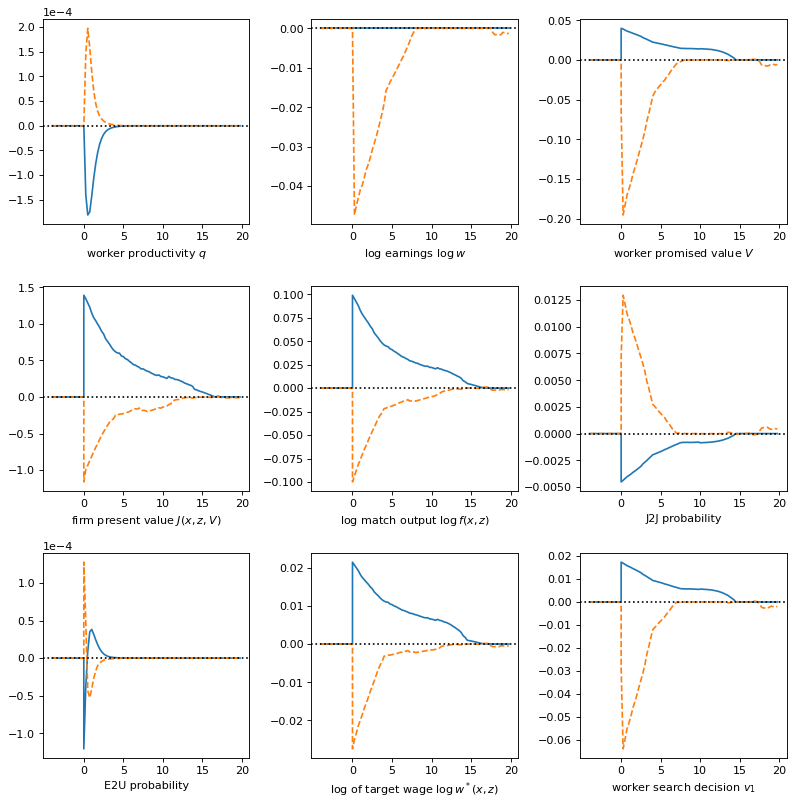

In [ ]:
cf_model_to_life(p,first_best=False, update_prod=False, pr_cache=False)

In [ ]:
from simulate import Simulator
sim = Simulator(model,p)
sim.

(5, 200, 0.95, 0.14, 6, 0.7, 0.3, 0.65, 1.0, 0.25, 2.0, 2.0) best so far: good with the transition rates (j2j and u2e slightly small, but not horrible), but the productivity moments are crazy small???? did I do them wrong? although in the BL ones are kinda crazy...

(5, 200, 0.95, 0.14, 6, 0.8, 0.4, 0.65, 1.0, 0.25, 0.5, 0.5) was good with j2j, but bad with layoffs

In [ ]:
#Moments comparison:
E2U annual: 1-(1-0.004116)**4 # soo this is a 1.6% layoff rate, tooo low
J2j annual: 1- (1 - 0.036997)**4 #14% j2j rate, way too high
Pr_new hire: 4% compared to 13% in the data #soooooo need to raise the pr_u2e even firther??? 49% aint enough? BL had 17% QUARTERLY transition probability
#Maybe this should be checked using annual data? Maybe pr_new_hire dooes not translate perfectly between quarterly and annual? hmmmm I'd guess so? 

0.13997602111275775

In [6]:
moms_unt_mean['autocov_ypw_alt']['ypw_l4']

np.float64(0.6972788225321755)

In [5]:
moms_unt_mean['wage_pass_ten']#['C(tenure)[T.15.0]:dypw']

coef
Intercept                0.260714
dypw                    -0.029017
C(tenure)[T.1.0]        -0.234174
C(tenure)[T.2.0]        -0.265843
C(tenure)[T.3.0]        -0.265482
C(tenure)[T.4.0]        -0.265506
C(tenure)[T.5.0]        -0.264684
C(tenure)[T.6.0]        -0.264581
C(tenure)[T.7.0]        -0.264694
C(tenure)[T.8.0]        -0.264646
C(tenure)[T.9.0]        -0.264740
C(tenure)[T.1.0]:dypw    0.042506
C(tenure)[T.2.0]:dypw    0.038396
C(tenure)[T.3.0]:dypw    0.048169
C(tenure)[T.4.0]:dypw    0.048103
C(tenure)[T.5.0]:dypw    0.049450
C(tenure)[T.6.0]:dypw    0.050814
C(tenure)[T.7.0]:dypw    0.049641
C(tenure)[T.8.0]:dypw    0.049506
C(tenure)[T.9.0]:dypw    0.051323
Name: regressions_mean, dtype: float64

In [15]:
moms_unt_mean['sep_ten']

coef
Intercept           0.043607
C(tenure)[T.1.0]   -0.035763
C(tenure)[T.2.0]   -0.042548
C(tenure)[T.3.0]   -0.043351
C(tenure)[T.4.0]   -0.043553
C(tenure)[T.5.0]   -0.043570
C(tenure)[T.6.0]   -0.043607
C(tenure)[T.7.0]   -0.043607
C(tenure)[T.8.0]   -0.043607
C(tenure)[T.9.0]   -0.043607
Name: regressions_mean, dtype: float64

In [ ]:
import sqlite3
import pandas as pd

db_path = "runs/quickscan/eval_log.sqlite"

# Read-only connection (works even while the optimizer is writing)
con = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True, timeout=5)

# Peek at the schema
print(pd.read_sql_query("PRAGMA table_info(eval_log);", con))

# How many evaluations so far?
n = pd.read_sql_query("SELECT COUNT(*) AS n FROM eval_log;", con).iloc[0,0]
print("rows logged:", n)

tail = pd.read_sql_query("""
  SELECT id, ts, obj
  FROM eval_log
  ORDER BY id DESC
  LIMIT 10;
""", con)
tail

best = pd.read_sql_query("""
  SELECT *
  FROM eval_log
  ORDER BY obj ASC
  LIMIT 1;
""", con)
best

In [6]:
model.Vf_W.min()


np.float64(39.634454607396236)

In [13]:
model.Vf_U

np.float64(-8.893649214830631)

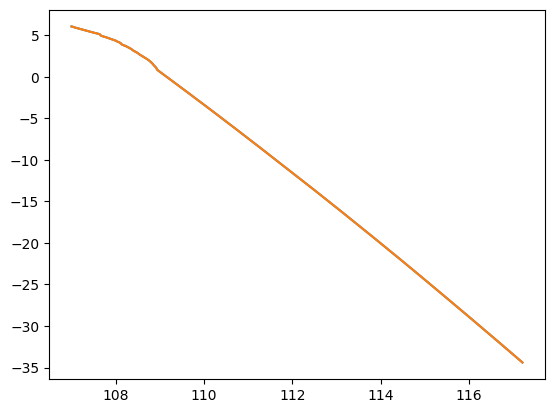

In [5]:
prod = p.z_0-1
plt.plot(model.Vf_W[prod, :, 0], model.Vf_J [prod, :, 0], label='1 senior value function')
plt.plot(model.Vf_W[prod, :, 0], model.Jp[prod, :, 0], label='1 senior value function')  
plt.show()

np.float64(0.029180667059879706)

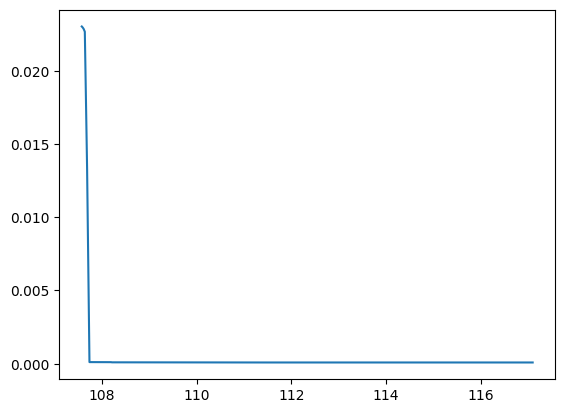

In [9]:
#plt.plot(model.Vf_W[p.z_0-2, :, 0], model.rho_star [p.z_0-2, :, 0], label='1 senior value function')
q=0
prod=p.z_0-0 #soomehow layoffs are higher in high productivity states???
plt.plot(model.Vf_W[prod, :, q], model.sep_star[prod, :, q], label='1 senior value function')  
model.sep_star.mean()

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_Rho_sep.pkl", "rb") as file:
    all_results = pickle.load(file)
results = get_results_for_p(p,all_results)

No results found for p = (3, 200, 6, 5, 11, 0.5, 0.5, 5.0, 0.85, 1.0, 1.0)
